# Filter Visualisation tutorial

In order to visualize filters you need a trained architecture and at least one subject to generate filters for.

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne.viz import plot_topomap
from meegnet.network import Model
from meegnet.dataloaders import EpochedDataset
from sklearn.decomposition import PCA

### Constants

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
sensors = ["MAG", "PLANAR1", "PLANAR2"]
n_channels = "ALL"
input_size = (3, 102, 400)

n_outputs = 2 # using auditory vs rest stimulus classification -> 2 classes
n_subjects = 1000 # For this tutorial we will only use a fraction of the data
n_samples = None # We will use all trials for each subject

# Setting up paths
classif = "mixed_auditory" # also used for naming files and for model name
save_path = f"/home/arthur/data/camcan/{classif}"
model_path = save_path

### Loading the model

In [3]:
# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 42 

# net option can be "meegnet", "eegnet" etc, see documentation
net_option = "meegnet" 

# name of the model
name = f"{classif}_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
# my_model.from_pretrained()
model_path = os.path.join(save_path, name + ".pt")
my_model.load(model_path)
print("Model Loaded.")

/home/arthur/.pyvenvs/camcan/lib/python3.12/site-packages/meegnet/network.py:958: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Model Loaded.


### Creating topomaps for the first CNN layer

The first layer of the meegnet CNN is a spatial de-mixing layer and is therefore a collection of vectors attaching importance weights to each of the sensor location. We can project those on a MNE-python topomap to visualise weight and sensor importance.

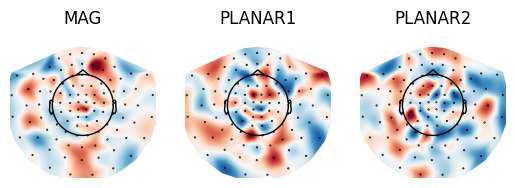

In [4]:
def generate_layer_topomap(weights, sensors, info, save=False):
    fig, axs = plt.subplots(1, len(sensors))
    
    for i, sens in enumerate(sensors):
        data = PCA(1).fit(weights[:,i].squeeze()).components_[0]
        ax = axs[i] if len(sensors) > 1 else axs
        im, _ = plot_topomap(
            data,
            info,
            show=False,
            axes=ax,
            contours=False,
        )
        ax.axis("off")
        ax.title.set_text(sens)
        
    if save:
        plt.savefig(os.path.join(viz_path, name, "filters.png"))
    plt.show()
    plt.close()

info = np.load("../camcan_sensor_locations.npy", allow_pickle=True).tolist()
model_weights = my_model.get_feature_weights()
weights = model_weights[0]

generate_layer_topomap(weights, sensors, info)

### Loading data

Next we load data based on the data framework established in the prepare data tutorial. We choose to only use one subject and one sample per label of the subject as an example.

In [5]:
dataset = EpochedDataset(
    sfreq=500, # sampling frequency of 500Hz
    n_subjects=n_subjects,
    sensortype='ALL', # we use MAG GRAD GRAD here
    lso=True,
    random_state=seed,
)
dataset.preload(os.path.join(save_path))
subj_list = dataset.subject_list

np.random.seed(seed)
random_subject_idx = np.random.choice(np.arange(len(subj_list)))
sub = np.random.choice(subj_list)

# Incrementing and changing subject in case there is an error with loading subject data
data = []
while data == []:
    dataset = EpochedDataset(
        sfreq=500, # sampling frequency of 500Hz
        sensortype='ALL', # we use MAG GRAD GRAD here
        lso=True,
        random_state=seed,
    )
    dataset.load(save_path, one_sub=sub)
    data = dataset.data

def pick_random():
    input_tensor = data.to(torch.float).cuda()
    random_index = np.random.choice(np.arange(len(input_tensor)))
    lab = dataset.labels[random_index]
    random_sample = input_tensor[random_index][np.newaxis, :]
    return random_sample.cuda(), int(lab)

random_samples, labels = [None, None], [None, None]
random_samples[0], labels[0] = pick_random()
while True:
    random_samples[1], labels[1] = pick_random()
    if labels[0] != labels[1]:
        break
        
print(f"subject: {sub}")

subject: CC420094


### Compute outputs for loaded data

We compute the outputs of each layer for the loaded data:

In [6]:
outputs = []
for rs, lab in zip(random_samples, labels):
    results = [my_model.net.feature_extraction[0](rs)]
    for layer in my_model.net.feature_extraction[1:-2]:
        results.append(layer(results[-1]))
    outputs.append((results[2:], lab)) # We ignore first two layers as they are "spatial" layers

### Generate figure

Finally we generate the figure

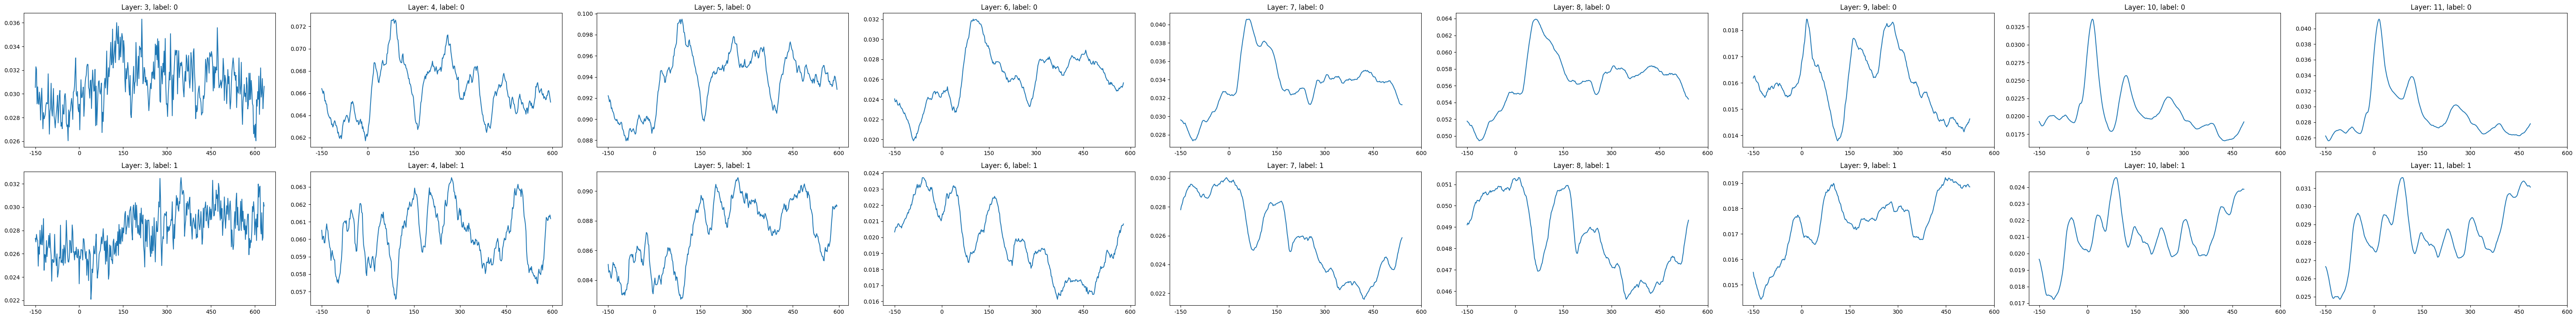

In [7]:
nrows, ncols = len(labels), len(outputs[0][0])
dx, dy = 4, 1
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=4*figsize)

for results, lab in outputs:
    for layer_idx, out in enumerate(results):
        layer_viz = out[0].detach().cpu()
        if len(layer_viz.shape) <= 1:
            continue
        filter_mean = None
        for filt in layer_viz:
            if filter_mean is None:
                filter_mean = filt/len(layer_viz)
            else:
                filter_mean += filt/len(layer_viz)
        axes[lab, layer_idx].plot(np.arange(len(filter_mean[0])), filter_mean[0])
        axes[lab, layer_idx].set_xticks((0, 75, 150, 225, 300, 375))
        axes[lab, layer_idx].set_xticklabels((-150, 0, 150, 300, 450, 600))
        axes[lab, layer_idx].title.set_text(f"Layer: {layer_idx+3}, label: {lab}") # correcting for ignored layers

plt.tight_layout()
# fig.savefig("figure")
plt.show()
plt.close()

In [21]:
from torch.utils.data import DataLoader    

dataset = EpochedDataset(
    sfreq=500, # sampling frequency of 500Hz
    sensortype='ALL', # we use MAG GRAD GRAD here
    n_subjects=10,
    lso=True,
    random_state=seed,
)
dataset.load(save_path)

batch_size = 32

dataloader = DataLoader(
    dataset.torchDataset(np.arange(128)),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
)

model = my_model.net

In [77]:
layer_id = 8
# Hook function to capture activations
def hook_fn(module, input, output):
    # Store the output activations
    activations.append(output)

activations = []
# Register the hook on the first convolutional layer
hook = model.feature_extraction[layer_id].register_forward_hook(hook_fn)

with torch.no_grad():
    for batch in dataloader:
        # Forward pass through the model
        X, y = batch
        X = X.view(-1, *input_size).to('cuda')
        _ = model(X)

        # Extract the activations after the first convolution layer
        # Here activations[0] will be the output of the conv1 layer
        output = activations[0]

        # Find the maximum activation value and the corresponding filter index
        max_activation, max_idx = torch.max(output, dim=1)  # Max over the filters (dim=1)

        # Find the filter with the maximum activation value
        max_filter_index = torch.argmax(max_activation, dim=-1) # gets us the filter that had highest activation in the time window for all batch samples
        max_filter_index = max_filter_index.to("cpu").squeeze()
        max_idx = max_idx.to("cpu").squeeze() # contains all filter idxs that were maximally activated for each sample for each time point
        final = [max_idx[i][max_filter_index[i]] for i in range(batch_size)] # gets us the ID of the maximum activated filter accross time for each sample

        # print(f"Filter with max activation: {max_filter_index}, Activation Value: {max_filter}")
        break  # For demonstration, we break after processing one batch

# Remove the hook
hook.remove()

In [78]:
# looks like filter 84/100 (at index 83) has the highest activation 
# for all of those data samples, but at diffrent timings as shown in max_filter_index

for maximum_activated_filter, where_in_the_signal, out, label in zip(final, max_filter_index, output.to('cpu').squeeze(), y.numpy()):
    print(label, maximum_activated_filter.item(), where_in_the_signal.item(), out[maximum_activated_filter.item(), where_in_the_signal.item()].item())

0.0 83 125 0.12718501687049866
1.0 83 0 0.11965161561965942
1.0 83 90 0.12794236838817596
1.0 83 157 0.14186017215251923
1.0 83 161 0.11681497097015381
0.0 83 113 0.12481728196144104
0.0 83 337 0.12316377460956573
1.0 83 153 0.11553863435983658
0.0 83 196 0.14263777434825897
0.0 83 229 0.14163367450237274
1.0 24 337 0.10403884947299957
0.0 83 108 0.1289699822664261
1.0 83 170 0.13727261126041412
0.0 83 122 0.13967783749103546
1.0 83 239 0.1360674500465393
1.0 83 273 0.12235632538795471
0.0 83 132 0.11668001860380173
1.0 83 336 0.1619366556406021
0.0 83 139 0.12483806163072586
1.0 83 15 0.1121051162481308
0.0 83 331 0.10780484974384308
0.0 83 267 0.1375722587108612
1.0 83 296 0.13206787407398224
0.0 83 108 0.14340919256210327
0.0 83 213 0.10896369069814682
0.0 83 120 0.10864654183387756
1.0 83 63 0.12002097070217133
0.0 83 98 0.1330660730600357
1.0 83 59 0.11176477372646332
1.0 83 0 0.115645632147789
1.0 83 89 0.11500932276248932
0.0 83 19 0.13526161015033722


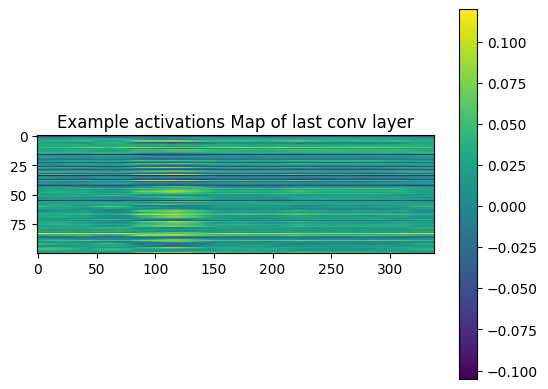

In [93]:
max_filter_index = 83
trial = 1

# activation_map = np.array([output[0, max_filter_index, :, :].detach().cpu().numpy().squeeze()]*10)
activation_map = output[trial, :, :, :].detach().cpu().numpy().squeeze()
plt.imshow(activation_map, cmap='viridis')
plt.title(f"Example activations Map of last conv layer")
plt.colorbar()
plt.show()

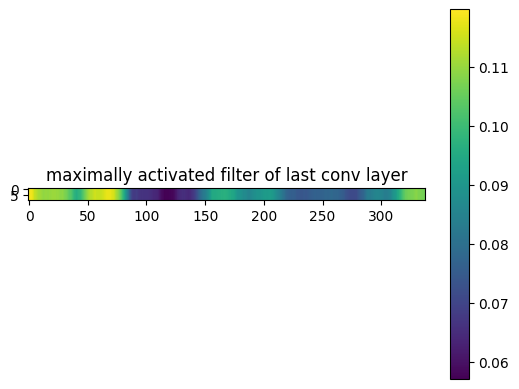

In [91]:

# activation_map = np.array([output[0, max_filter_index, :, :].detach().cpu().numpy().squeeze()]*10)
activation_map_single_trial = np.array([output[trial, max_filter_index, :, :].cpu().numpy().squeeze()]*10)
plt.imshow(activation_map_single_trial, cmap='viridis')
plt.title(f"maximally activated filter of last conv layer")
plt.colorbar()
plt.show()

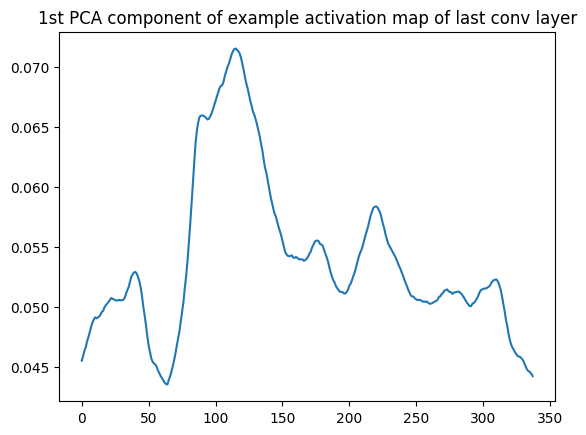

In [94]:
pca = PCA(100)
pca.fit(activation_map)
data = pca.components_[0]
plt.plot(data)
plt.title(f"1st PCA component of example activation map of last conv layer")
plt.show()
plt.close()

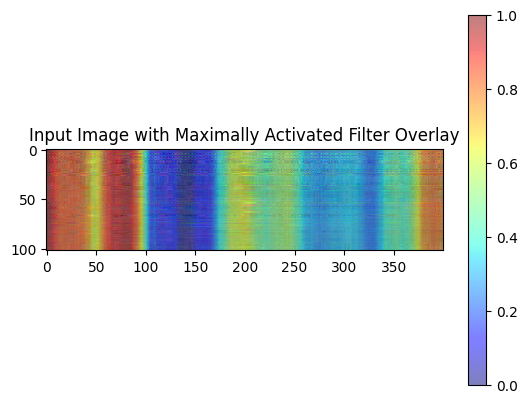

In [106]:
import torch.nn.functional as F

# Get the activation map as before
activation_map_single_trial = output[trial, max_filter_index, 0, :].detach().cpu().numpy()

activation_map_resized = F.interpolate(
    torch.tensor(activation_map).unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
    size=(102, 400),  # Resize to match the input dimensions
    mode='bilinear',
    align_corners=False
).squeeze().cpu().numpy()

# Overlay the activation map on the original image
img = X[trial].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for display

# Normalize activation map to [0, 1]
activation_map_resized = (activation_map_resized - activation_map_resized.min()) / (activation_map_resized.max() - activation_map_resized.min())

plt.imshow(img)
plt.imshow(activation_map_resized, alpha=0.5, cmap='jet')  # Overlay with transparency
plt.title(f"Input Image with Maximally Activated Filter Overlay")
plt.colorbar()
plt.show()